### Importing Important Library

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy import data
from torchtext.legacy.datasets import IMDB
from torchtext.legacy.data import Field, LabelField, BucketIterator

In [3]:
from tqdm import tqdm
import random
import sys

### Version chcek

In [4]:
f'Torch CUDA Version :{torch.version.cuda}'
f'Torch Version :{torch.__version__}'
f'Python Version :{sys.version}'

'Torch CUDA Version :10.1'

'Torch Version :1.8.1+cu101'

'Python Version :3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]'

### GPU Checker 

In [5]:
def gpu_check(seed_val = 1):
    print('The Seed is set to {}'.format(seed_val))
    if torch.cuda.is_available():
        print('Model will Run on CUDA.')
        print ("Type 'watch nvidia-smi' to monitor GPU\n")
        torch.cuda.manual_seed(seed_val)
        device = 'cuda'
    else:
        torch.manual_seed(seed_val)
        print ('Running in CPU')
        device = 'cpu'
    cuda = torch.cuda.is_available()
    return cuda,seed_val,device

In [6]:
cuda,SEED,device = gpu_check(seed_val=1234)

The Seed is set to 1234
Model will Run on CUDA.
Type 'watch nvidia-smi' to monitor GPU



In [7]:
!nvidia-smi

Thu May 27 12:47:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
def tokenize(s):
    return s.split(' ')

### Removing spacy for faster execution and loading custion tokenizer

In [9]:
TEXT = Field(tokenize = 'spacy',tokenizer_language = 'en_core_web_sm', lower = True,include_lengths = True)
# TEXT = Field(tokenize = tokenize,tokenizer_language = 'en_core_web_sm', lower = True)
LABEL = LabelField(dtype = torch.float)

### Creating the data split 

In [10]:
train_data, test_data = IMDB.splits(TEXT, LABEL,root ='./')

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:06<00:00, 13.5MB/s]


In [11]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [12]:
# display lenght of test and traing data
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 17500
Number of testing examples: 25000


In [13]:
# display single example at index 0
print(vars(train_data.examples[0]))

{'text': ['when', 'i', 'first', 'watched', 'robotboy', ',', 'i', 'found', 'it', 'fresh', 'and', 'interesting', ',', 'but', 'then', 'i', 'noticed', ',', 'that', 'with', 'each', 'episode', 'this', 'show', 'is', 'trying', 'to', 'teach', 'you', 'how', 'to', 'behave', 'yourself', ',', 'what', 'is', 'good', '/', 'bad', '.', 'episodes', 'became', 'predictable', '.', 'and', 'main', 'characters', 'are', 'not', 'interesting', '.', 'again', 'we', 'see', 'a', 'hyper', '-', 'smart', 'boy', ',', 'beaten', 'by', 'his', 'older', 'brother', ',', 'parents', 'who', 'do', "n't", 'understand', 'their', 'kid', ',', 'and', 'his', 'friends', ':', 'girl', 'and', 'fat', 'boy', '.', 'also', 'this', 'show', 'has', 'no', 'logic', '.', 'a', 'super', '-', 'modern', 'robot', 'who', 'works', 'on', 'two', 'aa', '-', 'size', 'batteries', ',', 'and', 'can', 'use', 'a', 'lot', 'of', 'weapons', '.', 'but', 'the', 'biggest', 'problem', 'is', 'the', 'difference', 'between', 'activated', 'and', 'super', '-', 'activated', 'mod

### Visualizing the data

In [14]:
line = ''
filenumber = 11

for i in train_data.examples[filenumber].text:
    line += i + ' '
line

train_data.examples[filenumber].label

"i found this to be a surprisingly light - handed touch at a 1950 's culture - clash movie . john wayne would hardly be one 's first choice as a cultural attache , being about as diplomatic with his good intentions as a bull - run in harrods . but this time he was left to play a part that was far more passive than his usual bluff persona , and he accomplished his task with style . the duke was a guy who really could act well . his facial expressions and body language could be extremely subtle.<br /><br />despite his considerable presence both as an actor and in terms of screen time , he failed to dominate this movie . many of his good intentions came a cropper . he had authority over nobody , and the intermittent narrative was provided by the titular geisha to whom he was the barbarian.<br /><br />the story of american attempts to curry favour with an isolationist japan was one of political intrigue rather than swashbuckling or hell - for - leather battles . i can not comment on the ac

'pos'

###  Build vocabulary for source and target from training data
 

In [15]:
# Build vocabulary for source and target from training data

TEXT.build_vocab(train_data, max_size=25_000)
LABEL.build_vocab(train_data)


In [16]:

# print(vars(TEXT.vocab))
print(f"Unique tokens in source vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in TRG vocabulary: {len(LABEL.vocab)}")

Unique tokens in source vocabulary: 25002
Unique tokens in TRG vocabulary: 2


### train and test iteartor

In [17]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch=True, # necessary for packed_padded_sequence
    device = device)

In [18]:
for batch in train_iterator:
    text, text_length = batch.text
#     logits = model(text, text_length)
    break

In [19]:
text_length
text.shape

tensor([135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 133], device='cuda:0')

torch.Size([135, 32])

### Creating Model

In [20]:
# Model class
class Model(nn.Module):
    def __init__(self, input_dim, output_dim,emb_dim, hidden_dim, n_layers, dropout):
        # input_dim <--- vocabulary size
        # output_dim <--- len ([positive, negative]) == 2 
        # emb_dim <--- embedding dimension of embedding matrix

        super(Model, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)

        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, src,Len):
        # shape: [source_len, batch_size]
        embedded = self.dropout(self.embedding(src)) # shape: [src_len, batch_size, embed_dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, Len.to('cpu'))
        output, (hidden, cell) = self.rnn(packed) 
        # output shape -> [batch, hidden_dim]
        # hiddden shape -> [n_layers, batch, hidden_dim]
        # cell shape -> [n_layers, batch, hidden_dim]
        output = self.fc1(hidden)
#         output = self.fc2(self.relu(output))
        return output.squeeze(0)

In [21]:
#initializing variables and hyper parameters
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(LABEL.vocab)

EMBEDDING_DIM = 100
HIDDEN_DIM = 256

N_LAYERS = 1
DROPOUT = 0.6

# initializing our model
model = Model(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [22]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
validation_loss = []
validation_accuracy = []

In [23]:
# loop and train our model
optimizer = optim.Adam(model.parameters(), lr=3e-3)

# defining learnig rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

criterion = nn.CrossEntropyLoss()


### Model training function

In [24]:

def train(EPOCH,model, iterator, optimizer=optimizer, criterion=criterion, clip=1,):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_count = 0
    pbar = tqdm(iterator)
    for i, batch in enumerate(pbar):
        src,data_len = batch.text
        src = src.to(device)
        trg = batch.label.to(device)
        trg = trg.long()
        optimizer.zero_grad()
        output = model(src,data_len)
        
        total_correct += torch.sum(torch.eq(output.argmax(1), trg))
        total_count+=len(trg)
        
        loss = criterion(output, trg)
        
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_description(desc= f'Epoch {EPOCH} Train data Batch No : {i} Loss : {loss.item():.3f} Accuracy : {total_correct/total_count * 100 :.2f}% ' )
    
    train_accuracy.append(total_correct/total_count)
    mean_loss = epoch_loss / len(iterator)
    train_loss.append(mean_loss)
    
    scheduler.step(mean_loss)


### Model Validation function

In [25]:

def evaluate(EPOCH,model, iterator, criterion,typ_loader):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    pbar  = tqdm(iterator)
    with torch.no_grad():
        
        for i,batch in enumerate(pbar):
            src,data_len = batch.text
            src = src.to(device)
            trg = batch.label.to(device)
            trg = trg.long()
            predictions = model(src,data_len)
            
            loss = criterion(predictions, trg)
            
            acc = binary_accuracy(predictions, trg)

            epoch_loss += loss.item()
            epoch_acc += acc
            if typ_loader == 'Valid data':
                validation_loss.append(loss)
                validation_accuracy.append(acc)
            elif typ_loader == 'Test data':
                test_loss.append(loss)
                test_accuracy.append(acc)

            pbar.set_description(desc= f'     -->{typ_loader} Loss : {loss.item():.3f} | Accuracy : {epoch_acc / len(iterator)* 100 :.2f}% ' )

In [26]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds.argmax(1) == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc.item()

In [27]:
total_epoch = 30
for epoch in range(total_epoch):
    result = train(epoch,model=model, iterator=train_iterator)
    evaluate(epoch,model,valid_iterator,criterion,'Valid data')
    evaluate(epoch,model,test_iterator,criterion,'Test data')

Epoch 0 Train data Batch No : 546 Loss : 0.449 Accuracy : 56.79% : 100%|██████████| 547/547 [00:13<00:00, 39.32it/s]
     -->Valid data Loss : 0.774 | Accuracy : 71.41% : 100%|██████████| 235/235 [00:02<00:00, 88.23it/s]
     -->Test data Loss : 0.506 | Accuracy : 71.77% : 100%|██████████| 782/782 [00:09<00:00, 81.80it/s]
Epoch 1 Train data Batch No : 546 Loss : 0.547 Accuracy : 71.53% : 100%|██████████| 547/547 [00:13<00:00, 40.02it/s]
     -->Valid data Loss : 0.445 | Accuracy : 78.55% : 100%|██████████| 235/235 [00:02<00:00, 89.43it/s]
     -->Test data Loss : 0.681 | Accuracy : 78.54% : 100%|██████████| 782/782 [00:08<00:00, 92.40it/s]
Epoch 2 Train data Batch No : 546 Loss : 0.420 Accuracy : 83.29% : 100%|██████████| 547/547 [00:13<00:00, 40.55it/s]
     -->Valid data Loss : 0.201 | Accuracy : 86.47% : 100%|██████████| 235/235 [00:02<00:00, 93.01it/s]
     -->Test data Loss : 0.601 | Accuracy : 85.86% : 100%|██████████| 782/782 [00:09<00:00, 84.30it/s]
Epoch 3 Train data Batch No 

In [ ]:
predict('Very good') # predict funciton will predict if this is positive or negative review.

In [ ]:
predict('i recommend to watch the movie once. It is mindblowing') # predict funciton will predict if this is positive or negative review.

Text(0.5, 1.0, 'train_acc')

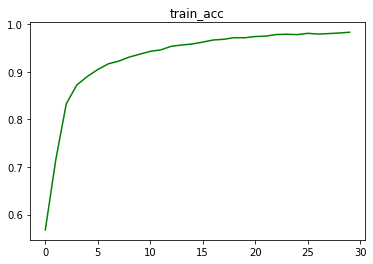

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy,'green')
plt.title('train_acc')

Text(0.5, 1.0, 'train_loss')

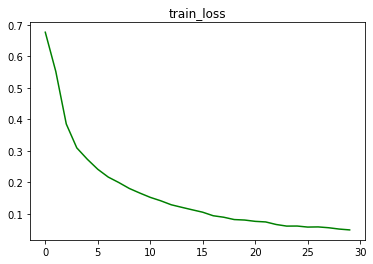

In [31]:
plt.plot(train_loss,'green')
plt.title('train_loss')

Text(0.5, 1.0, 'test_acc')

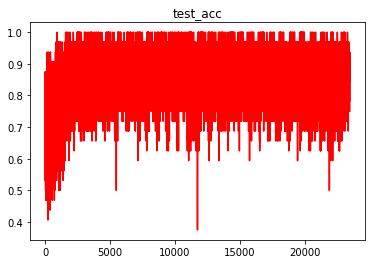

In [32]:
plt.plot(test_accuracy,'red')
plt.title('test_acc')

Text(0.5, 1.0, 'test_loss')

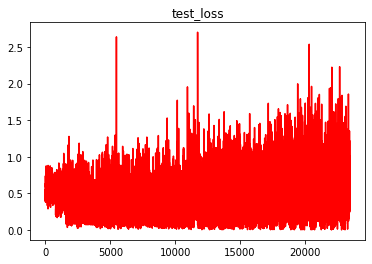

In [33]:
plt.plot(test_loss,'red')
plt.title('test_loss')

Text(0.5, 1.0, 'test_acc')

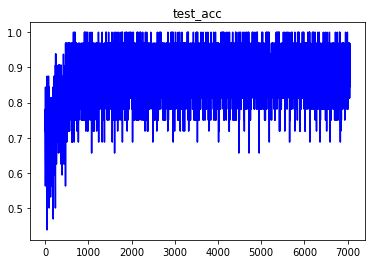

In [34]:
plt.plot(validation_accuracy,'blue')
plt.title('test_acc')

Text(0.5, 1.0, 'test_loss')

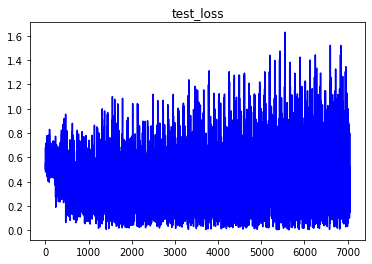

In [35]:
plt.plot(validation_loss,'blue')
plt.title('test_loss')